In [1]:
import time
import os
import gc

import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn.utils import shuffle, resample
from sklearn.metrics import mean_squared_error, r2_score
np.set_printoptions(precision=6, suppress=True)

import PIL
from PIL import Image

import tensorflow as tf
from tensorflow.keras import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
tf.__version__

'2.3.0'

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import (LinearLocator, MultipleLocator, FormatStrFormatter)
from matplotlib.dates import MonthLocator, WeekdayLocator, DateFormatter
from matplotlib import gridspec
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline

In [3]:
plt.rcParams['figure.figsize'] = ((8/2.54), (6/2.54))
plt.rcParams["font.family"] = "Arial"
plt.rcParams["mathtext.default"] = "rm"
plt.rcParams.update({'font.size': 11})
MARKER_SIZE = 15
cmap_m = ["#f4a6ad", "#f6957e", "#fccfa2", "#8de7be", "#86d6f2", "#24a9e4", "#b586e0", "#d7f293"]
cmap = ["#e94d5b", "#ef4d28", "#f9a54f", "#25b575", "#1bb1e7", "#1477a2", "#a662e5", "#c2f442"]

plt.rcParams['axes.spines.top'] = False
# plt.rcParams['axes.edgecolor'] = 
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['ytick.minor.width'] = 1

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


# Hyperparameters

In [5]:
# BEST_PATH = './models/pg_convnet.h5'
BEST_PATH = './models/pg_convnet' WHOLEMODEL
TRAINING_EPOCHS = 200
LEARNING_RATE = 0.001
EPSILON = 1e-06
BATCH_SIZE = 32

# Data preparation

In [6]:
l = np.load('./results/pg_dataset.npz', allow_pickle=True)
data_indices_2020S = l['data_indices_2020S']
output_label_2020S = l['output_label_2020S']
data_indices_2020W = l['data_indices_2020W']
output_label_2020W = l['output_label_2020W']
OUTPUT_MAXS = l['OUTPUT_MAXS']
OUTPUT_MINS = l['OUTPUT_MINS']

In [7]:
COLUMNS = ['node_len', 'node_dia', 'plant_h', 'leaf_area']

In [8]:
output_2020S_df = pd.DataFrame(output_label_2020S, index=data_indices_2020S, columns=COLUMNS)
output_2020W_df = pd.DataFrame(output_label_2020W, index=data_indices_2020W, columns=COLUMNS)

In [9]:
DIRECTORY = './images/2020_S/'
dir_list = os.listdir(DIRECTORY)
dataset_list = [direc for direc in dir_list if direc.startswith('LAI_OVER') or direc.startswith('LAI2_OVER')]
dataset_list.sort()

In [10]:
data_indices = []
input_images = []
output_labels = []
for DATE in output_2020S_df.index:
    for DIRECTORY in dataset_list:
        if DATE in DIRECTORY:
            file_list = os.listdir(f'./images/2020_S/{DIRECTORY}')
            file_list = [file for file in file_list if file.endswith('.jpg')]
            for FILE in file_list:
                TIME = pd.Timedelta(FILE.split()[-1].split('.')[0])
                if TIME >= pd.Timedelta('08:00:00') and TIME <= pd.Timedelta('16:00:00'):
                    image = Image.open(f'./images/2020_S/{DIRECTORY}/{FILE}')
                    data_indices.append(pd.Timestamp(DATE))
                    input_images.append(img_to_array(image))
                    output_labels.append(output_2020S_df.loc[DATE].values)

In [11]:
input_images = np.stack(input_images, axis=0)
output_labels = np.stack(output_labels, axis=0)
data_indices = np.array(data_indices)

In [12]:
print(len(data_indices))
print(input_images.shape)
print(output_labels.shape)

6392
(6392, 256, 256, 3)
(6392, 4)


In [13]:
gc.collect()

15

In [14]:
data_indices, input_images, output_labels = shuffle(data_indices, input_images, output_labels, random_state=4574)

In [15]:
N_TRAIN = int(input_images.shape[0]*.7)
train_input = input_images[:N_TRAIN, ...]
train_label = output_labels[:N_TRAIN, ...]
train_index = data_indices[:N_TRAIN]
val_input = input_images[N_TRAIN:, ...]
val_label = output_labels[N_TRAIN:, ...]
val_index = data_indices[N_TRAIN:]

In [16]:
datagen = ImageDataGenerator(
    rescale=1/255,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest')

In [17]:
train_iterator = datagen.flow(train_input, train_label, batch_size=BATCH_SIZE)
val_iterator = datagen.flow(val_input, val_label, batch_size=BATCH_SIZE)

In [18]:
print(f'number of training set: {train_input.shape[0]}')
print(f'number of validation set: {val_input.shape[0]}')

number of training set: 4474
number of validation set: 1918


In [19]:
gc.collect()

0

# Model construction

In [20]:
class ResidualBlock(layers.Layer):
    def __init__(self, num_filter, stride=1):
        super(ResidualBlock, self).__init__()
        self.n = num_filter
        self.s = stride
        
        self.conv1 = layers.Conv2D(filters=self.n, kernel_size=1, strides=1, kernel_initializer='glorot_normal', padding='same')
        self.norm1 = layers.BatchNormalization()
        self.act1 = layers.Activation(activations.relu)
        self.conv2 = layers.Conv2D(filters=self.n, kernel_size=3, strides=stride, kernel_initializer='glorot_normal', padding='same')
        self.norm2 = layers.BatchNormalization()
        self.act2 = layers.Activation(activations.relu)
        self.conv3 = layers.Conv2D(filters=self.n*4, kernel_size=1, strides=1, kernel_initializer='glorot_normal', padding='same')
        self.norm3 = layers.BatchNormalization()
        self.act3 = layers.Activation(activations.relu)

        self.downsample = Sequential()
        self.downsample.add(layers.Conv2D(filters=self.n*4, kernel_size=1, strides=stride, kernel_initializer='glorot_normal'))
        self.downsample.add(layers.BatchNormalization())

    def call(self, inp, training=None, **kwargs):
        shortcut = self.downsample(inp)

        inp = self.act1(self.norm1(self.conv1(inp), training=training))
        inp = self.act2(self.norm2(self.conv2(inp), training=training))
        inp = self.norm3(self.conv3(inp), training=training)

        oup = self.act3(layers.add([shortcut, inp]))

        return oup

In [21]:
def block_maker(num_filter, num_blocks, stride=1):
    res_block = tf.keras.Sequential()
    res_block.add(ResidualBlock(num_filter, stride=stride))

    for _ in range(1, num_blocks):
        res_block.add(ResidualBlock(num_filter, stride=1))

    return res_block

In [22]:
class ResNet2D(Model):
    def __init__(self, layer_params):
        super(ResNet2D, self).__init__()
        self.conv1 = layers.Conv2D(filters=64, kernel_size=7, strides=2, kernel_initializer='glorot_normal', padding="same")
        self.norm1 = layers.BatchNormalization()
        self.act1 = layers.Activation(activations.relu)
        self.pool1 = layers.MaxPool2D(pool_size=(3, 3), strides=2, padding="same")

        self.layer1 = block_maker(num_filter=64, num_blocks=layer_params[0])
        self.layer2 = block_maker(num_filter=128, num_blocks=layer_params[1], stride=2)
        self.layer3 = block_maker(num_filter=256, num_blocks=layer_params[2], stride=2)
        self.layer4 = block_maker(num_filter=512, num_blocks=layer_params[3], stride=2)

#         self.flat = layers.Flatten()
        self.avgpool = layers.GlobalAveragePooling2D()
        self.out_norm1 = layers.BatchNormalization()
        self.dropout = layers.Dropout(0.2)
        self.dense1 = layers.Dense(512)
        self.out_norm2 = layers.BatchNormalization()
        self.dense2 = layers.Dense(128)
        self.out_norm3 = layers.BatchNormalization()
        self.fc = layers.Dense(4)


    def call(self, inp, training=None, mask=None):
        inp = self.conv1(inp)
        inp = self.norm1(inp, training=training)
        inp = self.act1(inp)
        inp = self.pool1(inp)
        inp = self.layer1(inp, training=training)
        inp = self.layer2(inp, training=training)
        inp = self.layer3(inp, training=training)
        inp = self.layer4(inp, training=training)
        
#         inp = self.dense1(self.flat(inp))
        inp = self.avgpool(inp)
        inp = self.out_norm1(inp)
        inp = self.dropout(inp)
        inp = self.dense1(inp)
        inp = self.out_norm2(inp)
        inp = self.dense2(inp)
        inp = self.out_norm3(inp)
        output = self.fc(inp)

        return output

In [23]:
model = ResNet2D(layer_params=[2, 3, 2, 1])

In [24]:
cbs = callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=.2, patience=5, verbose=0, mode='auto',
    min_delta=0.0001, cooldown=0, min_lr=0)

sv = callbacks.ModelCheckpoint(
    BEST_PATH, monitor='val_loss', verbose=1,
    save_best_only=True, save_weights_only=True, mode='min', save_freq='epoch')

es = callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=5) 

In [25]:
opt = optimizers.Adam(learning_rate=LEARNING_RATE, epsilon=EPSILON)
model.compile(optimizer=opt, loss='mae')
model.fit(train_iterator, epochs=TRAINING_EPOCHS, validation_data=val_iterator,
              verbose=1, callbacks=[cbs, sv, es]) 

Epoch 1/200
140/140 [==============================] - ETA: 0s - loss: 0.3234
Epoch 00001: val_loss improved from inf to 0.27964, saving model to ./models/pg_convnet.h5
140/140 [==============================] - 83s 596ms/step - loss: 0.3234 - val_loss: 0.2796
Epoch 2/200
140/140 [==============================] - ETA: 0s - loss: 0.0639
Epoch 00002: val_loss improved from 0.27964 to 0.21874, saving model to ./models/pg_convnet.h5
140/140 [==============================] - 81s 581ms/step - loss: 0.0639 - val_loss: 0.2187
Epoch 3/200
140/140 [==============================] - ETA: 0s - loss: 0.0616
Epoch 00003: val_loss did not improve from 0.21874
140/140 [==============================] - 81s 581ms/step - loss: 0.0616 - val_loss: 0.2394
Epoch 4/200
140/140 [==============================] - ETA: 0s - loss: 0.0576
Epoch 00004: val_loss improved from 0.21874 to 0.05092, saving model to ./models/pg_convnet.h5
140/140 [==============================] - 81s 579ms/step - loss: 0.0576 - val_l

In [26]:
model.load_weights(BEST_PATH)

In [27]:
model.evaluate(val_iterator)

60/60 [==============================] - 24s 406ms/step - loss: 0.0360


0.03597453609108925

In [28]:
del(train_index)
del(train_input)
del(train_iterator)
del(train_label)

In [29]:
gc.collect()

8

In [30]:
pred_result = model.predict(val_input/255)

In [31]:
print(pred_result.shape)
print(val_label.shape)

(1918, 4)
(1918, 4)


In [32]:
val_label = (OUTPUT_MAXS - OUTPUT_MINS)*val_label + OUTPUT_MINS
pred_result = (OUTPUT_MAXS - OUTPUT_MINS)*pred_result + OUTPUT_MINS

In [33]:
pred_df = pd.DataFrame(np.concatenate([val_label, pred_result], axis=1), index=val_index)
pred_df.columns = ['label_node_len', 'label_node_dia', 'label_plant_h', 'label_leaf_area', 'pred_node_len', 'pred_node_dia', 'pred_plant_h', 'pred_leaf_area']

In [34]:
pred_df.to_csv('./results/model_output/pg_pred_result.csv')

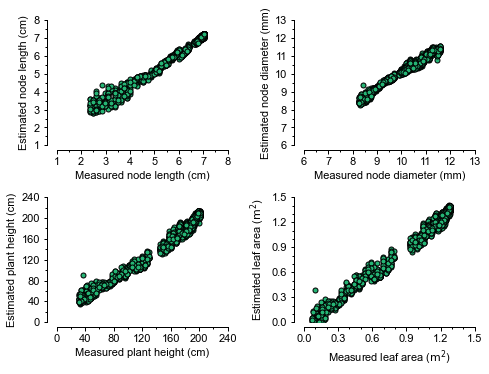

In [35]:
fig = plt.figure(figsize=((8/2.54*2.2), (6/2.54*2.2)))
grid = plt.GridSpec(2, 2)

ax0 = plt.subplot(grid[0])
ax1 = plt.subplot(grid[1])
ax2 = plt.subplot(grid[2])
ax3 = plt.subplot(grid[3])

ax0.spines['right'].set_visible(False)
ax0.spines['left'].set_position(('outward', 10))
ax0.spines['bottom'].set_position(('outward', 5))
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_position(('outward', 10))
ax1.spines['bottom'].set_position(('outward', 5))
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_position(('outward', 10))
ax2.spines['bottom'].set_position(('outward', 5))
ax3.spines['right'].set_visible(False)
ax3.spines['left'].set_position(('outward', 10))
ax3.spines['bottom'].set_position(('outward', 5))

ax0.plot(pred_df['label_node_len'], pred_df['pred_node_len'], 'o', ms=5, mec='k', c=cmap[3])
ax1.plot(pred_df['label_node_dia'], pred_df['pred_node_dia'], 'o', ms=5, mec='k', c=cmap[3])
ax2.plot(pred_df['label_plant_h'], pred_df['pred_plant_h'], 'o', ms=5, mec='k', c=cmap[3])
ax3.plot(pred_df['label_leaf_area'], pred_df['pred_leaf_area'], 'o', ms=5, mec='k', c=cmap[3])

ax0.xaxis.set_major_locator(LinearLocator(8))
ax0.xaxis.set_minor_locator(LinearLocator(15))
ax0.yaxis.set_major_locator(LinearLocator(8))
ax0.yaxis.set_minor_locator(LinearLocator(15))
ax0.set_xbound(1, 8)
ax0.set_ybound(1, 8)
ax1.xaxis.set_major_locator(LinearLocator(8))
ax1.xaxis.set_minor_locator(LinearLocator(15))
ax1.yaxis.set_major_locator(LinearLocator(8))
ax1.yaxis.set_minor_locator(LinearLocator(15))
ax1.set_xbound(6, 13)
ax1.set_ybound(6, 13)
ax2.xaxis.set_major_locator(LinearLocator(7))
ax2.xaxis.set_minor_locator(LinearLocator(13))
ax2.yaxis.set_major_locator(LinearLocator(7))
ax2.yaxis.set_minor_locator(LinearLocator(13))
ax2.set_xbound(0, 240)
ax2.set_ybound(0, 240)
ax3.xaxis.set_major_locator(LinearLocator(6))
ax3.xaxis.set_minor_locator(LinearLocator(16))
ax3.yaxis.set_major_locator(LinearLocator(6))
ax3.yaxis.set_minor_locator(LinearLocator(16))
ax3.set_xbound(0, 1.5)
ax3.set_ybound(0, 1.5)

ax0.set_xlabel('Measured node length (cm)')
ax0.set_ylabel('Estimated node length (cm)')
ax1.set_xlabel('Measured node diameter (mm)')
ax1.set_ylabel('Estimated node diameter (mm)')
ax2.set_xlabel('Measured plant height (cm)')
ax2.set_ylabel('Estimated plant height (cm)')
ax3.set_xlabel('Measured leaf area ($m^2$)')
ax3.set_ylabel('Estimated leaf area ($m^2$)')

fig.tight_layout()
plt.show()